## The SIR model with external infection seeding


We modify the usual SIR dynamical equations to the add an explicit seeding of initial cases, such as by returning travelers from afflicted regions.

\begin{align}
\dot S &= -\lambda(t)S - f(t) \\
\dot I &= \lambda(t)I - \gamma I + f(t) \\
\dot R &= \gamma I 
\end{align}

In the linear limit where $S(t) \approx S(0)$, $I(t)$ is decoupled and obeys the equation $$\dot{I}(t) = (\beta - \gamma) I + f(t)$$. We now consider a seeding function that grows exponentialy $$f(t) = f_0 e^{\tilde{\beta} t}$$ and integrate the equation to find 

\begin{equation}
    I(t)  = 
    \frac{f_0}{\tilde{\beta} - (\beta-\gamma)} \left( e^{\tilde{\beta} t} + e^{(\beta - \gamma) t}  \right)
    + I(0) e^{(\beta-\gamma)t}\,.
\end{equation}

A constant seeding rate is obtained for $\tilde{\beta} = 0$. We can now recognize two regimes:
1. **Transmission dominated:** $(\beta - \gamma) > \tilde{\beta}$  
2. **Seeding dominated:** $(\beta - \gamma) < \tilde{\beta}$
    
We can also compute the total number of cases seeded externally,
$$ N_{seeded} (t) = \frac{f_0}{\tilde{\beta}} (e^{\tilde{\beta} t} - 1)$$

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
#from matplotlib import rc; rc('text', usetex=True)

In [3]:
# Define the analytical solutions for I(t), N(t)

def analyticalSol(t, beta, gamma, betaBar, I0, f0) : 
    return (f0 / (betaBar - beta + gamma)) * np.exp(betaBar * t) + (I0 - f0 / (betaBar - beta + gamma)) * np.exp((beta-gamma)*t)

def numSeeded(t, betaBar, f0) :
    return (np.exp(betaBar * t)-1) * f0 / betaBar

## Transmission dominated case

In this case, the number of infected cases grows linearly at short times, until the infectious population becomes large enough to sustain the same infection rate. Therefore, at long times the exponential growth rate is identitcal to the none-seeded case. The total number of seeded cases becomes insiginificant compared to the resulting number of infections. The effect of seeding is therefore mostly to skip ahead on the save epidemic transmission curve. 

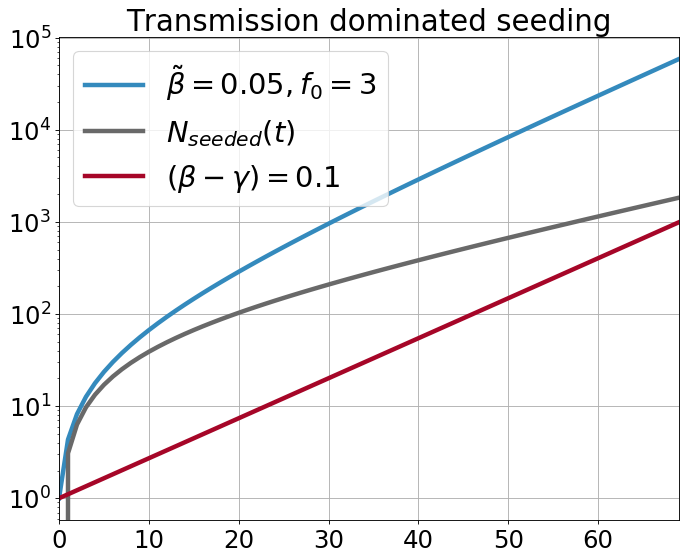

In [4]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


def solFunc0(t) :
    return analyticalSol(t, 0.2, 0.1, 0, 1, 0)

def solFunc1(t) :
    return analyticalSol(t, 0.2, 0.1, 0.05, 1, 3)

t = np.arange(70);
sol0 = solFunc0(t)
sol1 = solFunc1(t)
seed1 = numSeeded(t, 0.05, 3)

# plt.fill_between(t, 0, sol1, color="#348ABD", alpha=0.3)
plt.semilogy(t, sol1, '-', color="#348ABD", label='$\\tilde{\\beta} = 0.05,f_0=3$', lw=4)
plt.semilogy(t, seed1, '-', color="dimgrey", label='$N_{seeded}(t)$', lw=4)

# plt.fill_between(t, 0, (sol0), color='#A60628', alpha=0.3)
plt.semilogy(t, (sol0), '-', color='#A60628', label='$(\\beta-\\gamma)=0.1$', lw=4)


plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.title('Transmission dominated seeding');

## Seeding dominated case

In this case, growth rate of the infectious population at long times matches the growth rate of the seeded cases, and those dominate the total infected case count. In this case, the spread of the epidemic is greatly accelerated. 

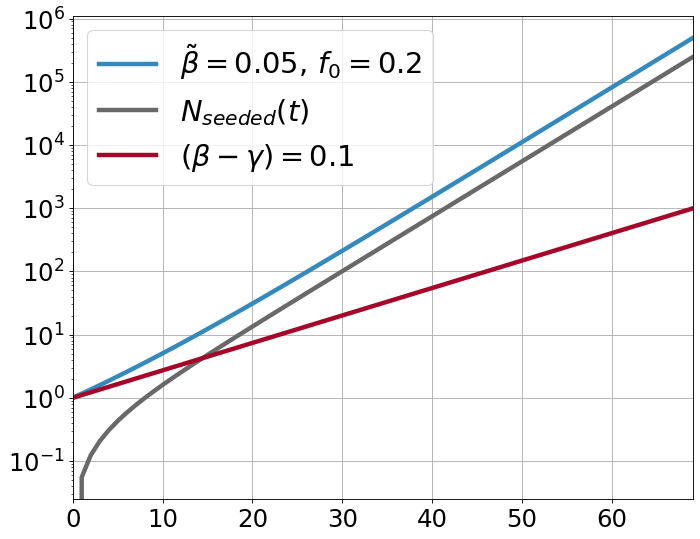

In [5]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})


def solFunc2(t) :
    return analyticalSol(t, 0.2, 0.1, 0.2, 1, 0.05)

t = np.arange(70);
sol0 = solFunc0(t)
sol2 = solFunc2(t)
seed1 = numSeeded(t, 0.2, 0.05)

# plt.fill_between(t, 0, sol1, color="#348ABD", alpha=0.3)
plt.semilogy(t, sol2, '-', color="#348ABD", label='$\\tilde{\\beta}=0.05,\, f_0 = 0.2$', lw=4)
plt.semilogy(t, seed1, '-', color="dimgrey", label='$N_{seeded}(t)$', lw=4)

# plt.fill_between(t, 0, (sol0), color='#A60628', alpha=0.3)
plt.semilogy(t, (sol0), '-', color='#A60628', label='$(\\beta - \\gamma) = 0.1$', lw=4)



plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)

## Non-linear Dynamics

We can run the full dynamics of these cases. We use the above seeding protocols for 7 weeks and then stop, corresponding to an imposed travel ban. Because of the elavated spreading rate in the seeding-dominated case, the infection rate drops once seeding is stopped. 

In [6]:
M = 1                  # the SIR model has no age structure
Ni = 1e5*np.ones(M)   # so there is only one age group 
N = np.sum(Ni)         # and the total population is the size of this age group

beta  = 0.2             # infection rate 
gIa   = 0.1            # recovery rate of asymptomatic infectives 
gIs   = 0.1            # recovery rate of symptomatic infectives 
alpha = 0              # fraction of asymptomatic infectives 
fsa   = 1              # the self-isolation parameter 


Ia0 = np.array([0])     # the SIR model has only one kind of infective 
Is0 = np.array([1])     # we take these to be symptomatic 
R0  = np.array([0])     # and assume there are no recovered individuals initially 
S0  = N-(Ia0+Is0+R0)    # so that the initial susceptibles are obtained from S + Ia + Is + R = N

vec = np.ones(M);
Toff1 = 49; Toff2 = 49; # 7 weeks
Tstop = 1; # one day

def stepFunc(t) :
    return 0.5 * (+ 1 - np.tanh(t/Tstop)) 

def seedRateFunc1(t) : 
    return  3.0 * vec * np.exp(0.05 * t) * stepFunc(t-Toff1)

def seedRateFunc2(t) : 
    return  0.05 * vec * np.exp(0.2 * t) * stepFunc(t-Toff2)

# there is no contact structure
def contactMatrix(t):   
    return np.identity(M) 

# duration of simulation and data file
Tf = 200;  Nt=Tf+1; 

# instantiate model
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
model = pyross.deterministic.SIR(parameters, M, Ni)

# simulate model 
data1 = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt, seedRate = seedRateFunc1)
data2 = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt, seedRate = seedRateFunc2)
data0 = model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nt)


t  = data0['t']
Is0  = data0['X'][:,2].flatten(); S0 = data0['X'][:,0].flatten();
Is1 = data1['X'][:,2].flatten(); S1 = data1['X'][:,0].flatten();
Is2 = data2['X'][:,2].flatten(); S2 = data2['X'][:,0].flatten();


numSeeded1 =int(numSeeded(Toff1, 0.05, 3))
numSeeded2 = int(numSeeded(Toff2, 0.2, 0.05))
print("The total number of seeded infections in the two cases: ", numSeeded1,", ", numSeeded2)

The total number of seeded infections in the two cases:  635 ,  4508


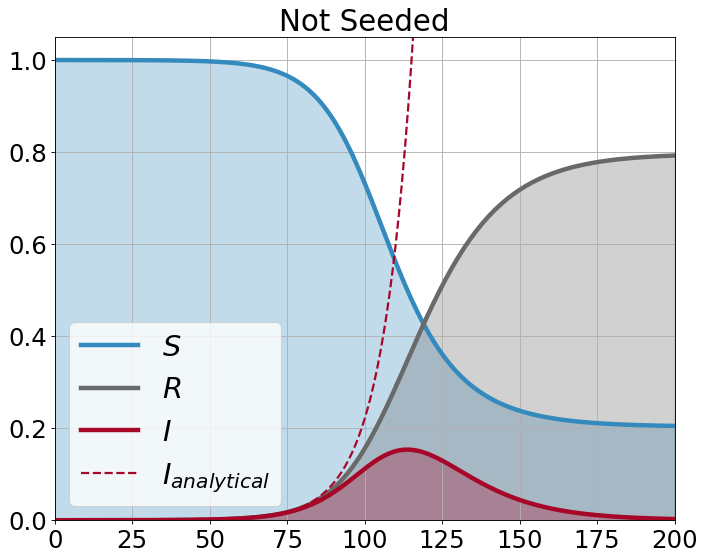

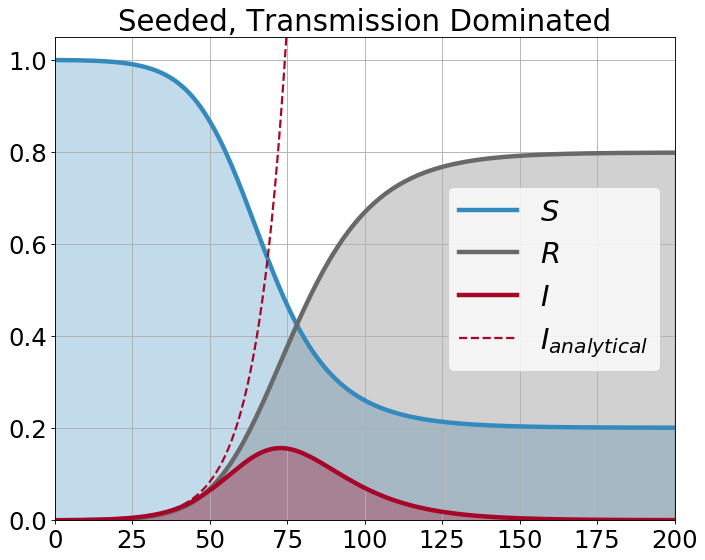

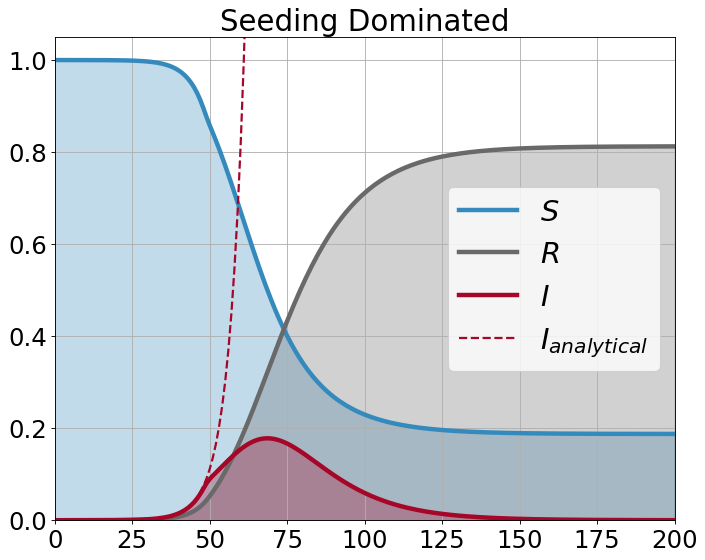

In [7]:
def plotData(t, S, Is, ref) :
    fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    plt.rcParams.update({'font.size': 22})
    
    plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
    plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)
    R=N-S-Is; 
    plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
    plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

    plt.fill_between(t, 0, (Is/N), color='#A60628', alpha=0.3)
    plt.plot(t, (Is/N), '-', color='#A60628', label='$I$', lw=4)
    plt.plot(t, (ref/N), '--', color='#A60628', label='$I_{analytical}$', lw=2)


    plt.legend(fontsize=26); plt.grid() 
    plt.autoscale(enable=True, axis='x', tight=True)
#     plt.ylim(0, np.max(Is) * 1.2)
    plt.ylim(0, 1.05)
    plt.xlim(0, np.max(t))

plotData(t, S0, Is0, solFunc0(t)); plt.title('Not Seeded')
plotData(t, S1, Is1, solFunc1(t)); plt.title('Seeded, Transmission Dominated')
plotData(t, S2, Is2, solFunc2(t)); plt.title('Seeding Dominated');